In [2]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

MODEL_NAME = "Rostlab/prot_bert" 
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # using mps instead of cuda for training on mac
#DEVICE = "cpu"  # use GPU if available, otherwise CPU
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 28
EPOCHS = 10
LR = 0.001

Using device: mps


In [3]:
import pandas as pd

records = []  # uniprot_ac, kingdom, type_, sequence, label
with open("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.fasta", "r") as f:
    current_record = None
    for line in f:
        if line.startswith(">"):
            if current_record is not None:
                if current_record["sequence"] is not None and current_record["label"] is not None:
                    # Save the previous record before starting a new one
                    records.append(current_record)
                else:
                    # If the previous record is incomplete, skip it
                    print("Skipping incomplete record:", current_record)
            # Start a new record
            uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
            current_record = {"uniprot_ac": uniprot_ac, "kingdom": kingdom, "type": type_, "sequence": None, "label": None}
        else:
            # Check if the line contains a sequence or a label
            if current_record["sequence"] is None:
                current_record["sequence"] = line.strip()
            elif current_record["label"] is None:
                current_record["label"] = line.strip()
            else:
                # If both sequence and label are already set, skip this line
                print("Skipping extra line in record:", current_record)
    # Save the last record if it's complete
    if current_record is not None:
        if current_record["sequence"] is not None and current_record["label"] is not None:
            records.append(current_record)
        else:
            print("Skipping incomplete record:", current_record)

"""
# Save the DataFrame to a CSV file
df_raw.to_csv("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.csv", index=False)
"""
# Print the number of records
print(f"Total records: {len(records)}")
df_raw = pd.DataFrame(records)
df_raw.head()


Total records: 25693


,uniprot_ac,kingdom,type,sequence,label
0,Q8TF40,EUKARYA,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,Q1ENB6,EUKARYA,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,P36001,EUKARYA,NO_SP,MDDISGRQTLPRINRLLEHVGNPQDSLSILHIAGTNGKETVSKFLT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,P55317,EUKARYA,NO_SP,MLGTVKMEGHETSDWNSYYADTQEAYSSVPVSNMNSGLGSMNSMNT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
4,P35583,EUKARYA,NO_SP,MLGAVKMEGHEPSDWSSYYAEPEGYSSVSNMNAGLGMNGMNTYMSM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [4]:
df = df_raw[~df_raw["label"].str.contains("P")]
df.describe()

,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
freq,1,20423,19036,41,16382


In [5]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

df_encoded = df.copy()
df_encoded["label"] = df_encoded["label"].apply(lambda x: [label_map[c] for c in x if c in label_map])
df_encoded = df_encoded[df_encoded["label"].map(len) > 0]  # Remove rows with empty label lists

# make random smaller dataset
#df_encoded = df_encoded.sample(frac=0.4, random_state=42)

sequences = df_encoded["sequence"].tolist()
label_seqs = df_encoded["label"].tolist()

df_encoded.describe()


,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
freq,1,20423,19036,41,16382


In [6]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
encoder = BertModel.from_pretrained(MODEL_NAME)
encoder.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [7]:
# Stratify by sequence length to avoid ValueError
train_seqs, test_seqs, train_label_seqs, test_label_seqs = train_test_split(
    sequences, label_seqs, test_size=0.3, random_state=42
)

In [8]:
# Load the data 
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # preprocess the sequence (insert spaces between amino acids)
        seq_processed = " ".join(list(seq))
        labels = self.label_seqs[idx]
        # Tokenize the sequence (padding to ensure all sequences are the same length -> 512 tokens) 
        encoded = tokenizer(seq_processed, return_tensors="pt",
                            padding="max_length", truncation=True, max_length=512)
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        
        # Build a label tensor of the same length as input_ids.
        # For tokens beyond the original sequence length, assign -100 so that loss func ignores them.
        orig_length = len(seq)
        token_labels = []
        
        for i in range(input_ids.size(0)):
            if i == 0 or i > orig_length:  
                token_labels.append(-100)  # ignore padding tokens
            else:
                # Use the already encoded label directly
                token_labels.append(labels[i-1])
        labels_tensor = torch.tensor(token_labels)
        
        return {
            'input_ids': input_ids, # tokenized and padded 
            'attention_mask': attention_mask, # differentiate between padding and non-padding tokens
            'labels': labels_tensor # aligned label tensor
        }

train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, encoder_model, num_labels):
        super().__init__()
        self.encoder = encoder_model  
        self.dropout = nn.Dropout(0.2)
        hidden_size = self.encoder.config.hidden_size
        # detects local features in the sequence
        self.conv = nn.Conv1d(in_channels=hidden_size, out_channels=1024, kernel_size=8, dilation=2, padding=7)
        # Normalize the convolution output (expects shape: (batch, 1024, seq_len))
        self.bn_conv = nn.BatchNorm1d(1024)
        # 2 layer long short term memory network
        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)
        # dense layer
        self.classifier = nn.Linear(512 * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)



    def forward(self, input_ids, attention_mask, labels=None):
        # Encode with BERT
        encoder_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = encoder_output.last_hidden_state  # (batch, seq_len, hidden_size)

        #  CNN 1
        # Apply conv, then batch normalization and ReLU
        x_conv = self.conv(hidden_states.transpose(1, 2))  # (batch, 1024, seq_len)
        x_conv = self.bn_conv(x_conv)
        x_conv = F.relu(x_conv)                          # (batch, 1024, seq_len)

        # Transpose CNN output for LSTM: (batch, seq_len, features)
        x_lstm_input = x_conv.transpose(1, 2)           # (batch, seq_len, 1024)

        # Apply BiLSTM
        lstm_out, _ = self.lstm(x_lstm_input)            # (batch, seq_len, 1024)

        # Classifier to num_labels
        x_linear = self.classifier(lstm_out)             # (batch, seq_len, num_labels)
        logits = self.dropout(x_linear)                  # (batch, seq_len, num_labels)

        if labels is not None:
            # Replace ignore-index (-100) with a valid label (0) since CRF doesn't support -100
            mod_labels = labels.clone()
            mod_labels[labels == -100] = 0
            loss = -self.crf(logits, mod_labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            predictions = self.crf.decode(logits, mask=attention_mask.bool())
            return predictions



In [10]:
from transformers import get_linear_schedule_with_warmup

# Initialize the model
model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)

# optimizer 
optimizer = torch.optim.AdamW([
    {"params": model.encoder.encoder.layer[-4:].parameters(), "lr": 5e-6},
    {"params": model.conv.parameters(), "lr": 1e-3},
    {"params": model.classifier.parameters(), "lr": 1e-3},
    {"params": model.lstm.parameters(), "lr": 1e-3},
    {"params": model.crf.parameters(), "lr": 1e-3},
], weight_decay=0.01)  # adjust weight_decay as needed

total_steps = len(train_loader) * EPOCHS
# scheduler for learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
# Counter({'I': 1204001, 'O': 362643, 'S': 85526, 'M': 74445, 'L': 46065, 'T': 22272, 'P': 951})
class_counts = [1204001, 85526, 22272, 46865, 74445, 362643]  # Count for each class (I, S, T, L, M, O)
# hopefully deals with the class imbalance
weights = torch.tensor([1.0 / count for count in class_counts], device=DEVICE)

# loss function that ignores the padding tokens (-100)
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-100)

In [11]:
# Compute sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [12]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import matthews_corrcoef

def evaluate_model(model, data_loader, loss_fn, test_label_seqs):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for batch in tqdm(data_loader, desc="Evaluation", leave=False):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits.reshape(-1, NUM_CLASSES), labels.reshape(-1))
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        # Flatten and filter out padding tokens (-100)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        valid_idx = labels_flat != -100
        all_preds.extend(preds_flat[valid_idx].cpu().numpy())
        all_labels.extend(labels_flat[valid_idx].cpu().numpy())
    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
    
    try:
        mcc = matthews_corrcoef(all_labels, all_preds)
    except ImportError:
        mcc = None

    print("Classification Report:")
    print(report)
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Token-level Accuracy: {acc:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc if mcc is not None else 'N/A'}")
    
    # Compute sequence-level accuracy if the function is defined
    try:
        seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
        print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")
    except Exception as e:
        seq_acc_val = None
        print("Sequence Level Accuracy could not be computed:", e)
    
    return avg_loss, acc, mcc, seq_acc_val


In [24]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.amp import autocast, GradScaler

writer = SummaryWriter(log_dir="/Users/jonas/Desktop/Uni/PBL/logs/prot_bert_linear_classifier_v5")
scaler = GradScaler()

# Freeze encoder parameters initially
for param in model.encoder.parameters():
    param.requires_grad = False

model.encoder.gradient_checkpointing_enable()  # Enable gradient checkpointing for memory efficienc

for epoch in range(EPOCHS):
    model.train()

    # Gradually unfreeze subsets of encoder layers for efficiency
    if epoch == 4:
        try:
            for param in model.encoder.encoder.layer[-4:].parameters():
                param.requires_grad = True
            print("Unfreezing last 4 layers of encoder")
        except RuntimeError as e:
            print("Error unfreezing parameters in Epoch 4:", e)
            torch.mps.empty_cache() # Clear cache immediately on error
            continue

    elif epoch == 7:
        try:
            for param in model.encoder.encoder.layer[-7:].parameters():
                param.requires_grad = True
            print("Unfreezing last 7 layers of encoder")
        except RuntimeError as e:
            print("Error unfreezing parameters in Epoch 7:", e)
            torch.mps.empty_cache() # Clear cache immediately on error
            continue

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
    total_loss = 0  # total epoch loss

    for batch in pbar:
        try:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            token_labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()  # reset gradients
            with autocast(device_type=DEVICE):  # mixed precision training
                loss = model(input_ids, attention_mask, token_labels)  # forward pass

            loss = model(input_ids, attention_mask, token_labels)  # forward pass
            scaler.scale(loss).backward()      # backpropagation
            scaler.unscale_(optimizer) # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
            scaler.step(optimizer)     # update weights
            scaler.update()           # update scaler
            scheduler.step()     # update learning rate

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        except RuntimeError as e:
                print("Error during training:", e)
                torch.mps.empty_cache()
                continue

    torch.mps.empty_cache()  # Clear cache at the end of each epoch
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}")
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

writer.flush()
writer.close()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/10:   0%|          | 0/640 [00:00<?, ?batch/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Epoch 1/10: 100%|██████████| 640/640 [1:26:11<00:00,  8.08s/batch, loss=7.83]


Epoch 1, Loss: 25.4307


Epoch 2/10: 100%|██████████| 640/640 [1:27:10<00:00,  8.17s/batch, loss=21.9]


Epoch 2, Loss: 9.3487


Epoch 3/10: 100%|██████████| 640/640 [1:26:39<00:00,  8.12s/batch, loss=2.56] 


Epoch 3, Loss: 4.9460


Epoch 4/10: 100%|██████████| 640/640 [1:26:19<00:00,  8.09s/batch, loss=1.69] 


Epoch 4, Loss: 3.3207
Unfreezing last 4 layers of encoder


Epoch 5/10: 100%|██████████| 640/640 [1:35:44<00:00,  8.98s/batch, loss=2.36] 


Epoch 5, Loss: 2.5507


Epoch 6/10:   0%|          | 2/640 [00:24<2:05:48, 11.83s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.98 GB, other allocations: 7.97 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   1%|          | 5/640 [00:33<48:06,  4.55s/batch, loss=2.21]  

Error during training: MPS backend out of memory (MPS allocated: 9.98 GB, other allocations: 8.07 GB, max allowed: 18.13 GB). Tried to allocate 448.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.98 GB, other allocations: 8.07 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   1%|▏         | 8/640 [00:33<21:58,  2.09s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   2%|▏         | 14/640 [00:34<07:49,  1.33batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   3%|▎         | 20/640 [00:34<03:34,  2.89batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   4%|▍         | 25/640 [00:34<02:00,  5.08batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   4%|▍         | 28/640 [00:34<01:29,  6.82batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   5%|▌         | 34/640 [00:34<00:55, 10.85batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   6%|▋         | 40/640 [00:35<00:41, 14.55batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   7%|▋         | 43/640 [00:35<00:36, 16.20batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   8%|▊         | 49/640 [00:35<00:31, 18.93batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   9%|▊         | 55/640 [00:35<00:29, 19.92batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:   9%|▉         | 58/640 [00:36<00:28, 20.41batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  10%|█         | 64/640 [00:36<00:26, 21.51batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  10%|█         | 67/640 [00:36<00:27, 20.54batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  11%|█▏        | 73/640 [00:36<00:26, 21.34batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  12%|█▏        | 79/640 [00:37<00:25, 22.23batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  13%|█▎        | 82/640 [00:37<00:26, 21.12batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  14%|█▍        | 88/640 [00:37<00:25, 21.99batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  15%|█▍        | 94/640 [00:37<00:25, 21.46batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 6/10:  16%|█▋        | 105/640 [00:41<01:44,  5.11batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 10.58 GB, other allocations: 8.13 GB, max allowed: 18.13 GB). Tried to allocate 28.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allo

Epoch 6/10:  19%|█▊        | 119/640 [00:41<00:44, 11.71batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  21%|██▏       | 136/640 [00:41<00:20, 24.43batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  24%|██▍       | 152/640 [00:42<00:12, 38.76batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  26%|██▋       | 168/640 [00:42<00:09, 50.37batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  29%|██▉       | 184/640 [00:42<00:07, 61.99batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  31%|███▏      | 200/640 [00:42<00:06, 68.61batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  34%|███▍      | 216/640 [00:43<00:06, 70.38batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  36%|███▋      | 232/640 [00:43<00:05, 72.32batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  39%|███▉      | 249/640 [00:43<00:05, 71.21batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  42%|████▏     | 266/640 [00:43<00:04, 75.39batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  44%|████▍     | 283/640 [00:43<00:04, 77.55batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  47%|████▋     | 300/640 [00:44<00:04, 74.57batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  50%|████▉     | 317/640 [00:44<00:04, 77.39batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  51%|█████     | 325/640 [00:44<00:04, 77.69batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  53%|█████▎    | 342/640 [00:44<00:03, 74.69batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  56%|█████▌    | 359/640 [00:44<00:03, 77.24batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  59%|█████▉    | 376/640 [00:45<00:03, 73.22batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  61%|██████▏   | 392/640 [00:45<00:03, 75.93batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  64%|██████▍   | 410/640 [00:45<00:02, 78.06batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  67%|██████▋   | 426/640 [00:45<00:02, 73.18batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  69%|██████▉   | 444/640 [00:46<00:02, 76.97batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  72%|███████▏  | 460/640 [00:46<00:02, 72.98batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  73%|███████▎  | 468/640 [00:46<00:02, 74.55batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.79 GB, max allowed: 18.13 GB). Tried to all

Epoch 6/10:  74%|███████▍  | 474/640 [01:02<01:47,  1.55batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  74%|███████▍  | 475/640 [01:03<01:48,  1.51batch/s, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate

Epoch 6/10:  75%|███████▌  | 481/640 [01:20<03:35,  1.36s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  75%|███████▌  | 482/640 [01:24<04:00,  1.52s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.31 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 

Epoch 6/10:  76%|███████▌  | 486/640 [01:36<04:58,  1.94s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  76%|███████▌  | 487/640 [01:40<05:23,  2.11s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 490/640 [01:51<06:25,  2.57s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 491/640 [01:55<06:46,  2.73s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 493/640 [02:02<07:20,  2.99s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 495/640 [02:10<07:47,  3.22s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 496/640 [02:14<07:54,  3.30s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 497/640 [02:17<08:02,  3.37s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 498/640 [02:21<08:02,  3.40s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 499/640 [02:23<07:20,  3.12s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 500/640 [02:27<07:38,  3.27s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 501/640 [02:30<07:52,  3.40s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 502/640 [02:31<06:07,  2.66s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▊  | 503/640 [02:35<06:39,  2.91s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 504/640 [02:38<07:07,  3.14s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 505/640 [02:42<07:23,  3.28s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 506/640 [02:46<07:44,  3.46s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 507/640 [02:50<08:01,  3.62s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 508/640 [02:51<06:12,  2.83s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|███████▉  | 509/640 [02:51<04:40,  2.14s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|███████▉  | 510/640 [02:55<05:38,  2.61s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|███████▉  | 511/640 [02:59<06:15,  2.91s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 512/640 [03:03<06:50,  3.20s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 513/640 [03:06<07:00,  3.31s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 514/640 [03:07<05:07,  2.44s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 515/640 [03:10<05:57,  2.86s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████  | 517/640 [03:14<04:33,  2.23s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████  | 518/640 [03:18<05:21,  2.64s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████  | 519/640 [03:19<04:42,  2.34s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████▏ | 520/640 [03:23<05:32,  2.77s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████▏ | 521/640 [03:27<06:09,  3.11s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 522/640 [03:31<06:24,  3.26s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 523/640 [03:34<06:35,  3.38s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 524/640 [03:38<06:50,  3.54s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 525/640 [03:39<04:55,  2.57s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 526/640 [03:42<05:27,  2.87s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 527/640 [03:46<06:03,  3.21s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▎ | 528/640 [03:50<06:14,  3.34s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 529/640 [03:54<06:31,  3.52s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 530/640 [03:57<06:32,  3.57s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 531/640 [03:59<05:07,  2.82s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 532/640 [04:02<05:40,  3.15s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 533/640 [04:06<06:01,  3.38s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 534/640 [04:07<04:20,  2.46s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▎ | 535/640 [04:10<04:43,  2.70s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 536/640 [04:13<04:56,  2.85s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 537/640 [04:17<05:12,  3.03s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 538/640 [04:20<05:20,  3.15s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.31 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 539/640 [04:24<05:37,  3.35s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 540/640 [04:28<05:51,  3.51s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▍ | 541/640 [04:31<05:52,  3.56s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▍ | 542/640 [04:35<05:54,  3.62s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▍ | 543/640 [04:39<06:00,  3.71s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 544/640 [04:39<04:17,  2.68s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 545/640 [04:43<04:31,  2.85s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 546/640 [04:47<05:00,  3.19s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 547/640 [04:50<05:15,  3.39s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 548/640 [04:54<05:25,  3.53s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 549/640 [04:58<05:18,  3.50s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.31 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 550/640 [04:59<04:15,  2.84s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 551/640 [05:03<04:33,  3.08s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▋ | 552/640 [05:06<04:49,  3.28s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 554/640 [05:10<03:29,  2.44s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 555/640 [05:14<03:47,  2.68s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 556/640 [05:17<04:07,  2.95s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 557/640 [05:21<04:24,  3.19s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 558/640 [05:25<04:35,  3.36s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 559/640 [05:28<04:39,  3.46s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 560/640 [05:31<04:28,  3.36s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 561/640 [05:36<04:54,  3.73s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 562/640 [05:40<04:59,  3.85s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 563/640 [05:44<04:52,  3.80s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 564/640 [05:48<04:45,  3.75s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 565/640 [05:51<04:41,  3.75s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 566/640 [05:55<04:36,  3.73s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▊ | 567/640 [05:55<03:16,  2.69s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 568/640 [05:58<03:25,  2.86s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 569/640 [06:02<03:28,  2.94s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 570/640 [06:06<03:46,  3.23s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 571/640 [06:09<03:58,  3.46s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 572/640 [06:10<02:50,  2.51s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|████████▉ | 573/640 [06:14<03:15,  2.92s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|████████▉ | 574/640 [06:18<03:31,  3.20s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|████████▉ | 575/640 [06:21<03:38,  3.36s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 576/640 [06:25<03:44,  3.51s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 577/640 [06:29<03:48,  3.62s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 578/640 [06:33<03:46,  3.65s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 579/640 [06:37<03:52,  3.80s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 580/640 [06:37<02:44,  2.74s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 581/640 [06:41<02:55,  2.97s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.31 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 582/640 [06:44<03:03,  3.17s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 583/640 [06:46<02:42,  2.85s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████▏| 584/640 [06:50<03:00,  3.23s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████▏| 585/640 [06:54<03:09,  3.45s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 586/640 [06:58<03:14,  3.60s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 587/640 [07:02<03:16,  3.71s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 588/640 [07:06<03:15,  3.76s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 589/640 [07:10<03:15,  3.83s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 590/640 [07:14<03:14,  3.88s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 591/640 [07:18<03:11,  3.91s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▎| 592/640 [07:22<03:07,  3.91s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 593/640 [07:26<03:04,  3.92s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 594/640 [07:30<03:02,  3.97s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 595/640 [07:34<02:56,  3.93s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.28 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 596/640 [07:37<02:46,  3.78s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 597/640 [07:41<02:43,  3.80s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 598/640 [07:45<02:39,  3.79s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▎| 599/640 [07:49<02:39,  3.89s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 600/640 [07:53<02:34,  3.85s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 601/640 [07:57<02:31,  3.89s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 602/640 [08:01<02:29,  3.93s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 603/640 [08:05<02:26,  3.95s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 604/640 [08:09<02:21,  3.94s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▍| 605/640 [08:13<02:19,  3.98s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▍| 606/640 [08:13<01:37,  2.88s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▍| 607/640 [08:17<01:42,  3.12s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 608/640 [08:21<01:48,  3.39s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 609/640 [08:25<01:48,  3.50s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 610/640 [08:25<01:16,  2.54s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 611/640 [08:25<00:55,  1.90s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 612/640 [08:29<01:08,  2.45s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 613/640 [08:33<01:17,  2.89s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 614/640 [08:37<01:24,  3.25s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 615/640 [08:38<01:01,  2.44s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▋| 616/640 [08:42<01:08,  2.85s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▋| 617/640 [08:45<01:13,  3.19s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 618/640 [08:51<01:23,  3.81s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 619/640 [08:55<01:19,  3.80s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 620/640 [08:55<00:55,  2.75s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 621/640 [08:59<00:58,  3.09s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 622/640 [09:03<00:59,  3.32s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 623/640 [09:06<00:59,  3.50s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 624/640 [09:10<00:58,  3.65s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 625/640 [09:11<00:39,  2.64s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 626/640 [09:14<00:41,  2.95s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 627/640 [09:18<00:42,  3.27s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 628/640 [09:22<00:41,  3.48s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 629/640 [09:26<00:38,  3.54s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 630/640 [09:30<00:36,  3.64s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▊| 631/640 [09:34<00:32,  3.67s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 632/640 [09:37<00:28,  3.58s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.31 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 633/640 [09:41<00:25,  3.62s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 634/640 [09:45<00:22,  3.71s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 635/640 [09:49<00:18,  3.73s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|█████████▉| 637/640 [09:53<00:08,  2.70s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.42 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.23 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|█████████▉| 638/640 [09:53<00:04,  2.00s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.25 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|█████████▉| 639/640 [09:57<00:02,  2.51s/batch, loss=2.21]

Error during training: MPS backend out of memory (MPS allocated: 8.39 GB, other allocations: 9.69 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|██████████| 640/640 [09:58<00:00,  1.07batch/s, loss=2.21]


Error during training: MPS backend out of memory (MPS allocated: 8.46 GB, other allocations: 10.13 GB, max allowed: 18.13 GB). Tried to allocate 14.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 6, Loss: 0.0035


Epoch 7/10:   1%|▏         | 8/640 [00:00<00:08, 72.37batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:   2%|▎         | 16/640 [00:00<00:08, 75.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   4%|▍         | 24/640 [00:00<00:08, 68.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:   6%|▋         | 40/640 [00:00<00:08, 72.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:   9%|▉         | 56/640 [00:00<00:08, 71.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  11%|█▏        | 72/640 [00:00<00:07, 75.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  14%|█▍        | 88/640 [00:01<00:07, 71.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  16%|█▋        | 105/640 [00:01<00:07, 74.69batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  19%|█▉        | 121/640 [00:01<00:06, 76.98batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  20%|██        | 129/640 [00:01<00:07, 71.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  21%|██▏       | 137/640 [00:01<00:06, 73.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  23%|██▎       | 145/640 [00:01<00:06, 75.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  24%|██▍       | 154/640 [00:02<00:06, 76.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  25%|██▌       | 162/640 [00:02<00:06, 70.77batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  27%|██▋       | 170/640 [00:02<00:06, 73.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  28%|██▊       | 178/640 [00:02<00:06, 69.79batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  29%|██▉       | 186/640 [00:02<00:06, 72.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  30%|███       | 194/640 [00:02<00:05, 74.36batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  32%|███▏      | 202/640 [00:02<00:06, 70.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  33%|███▎      | 210/640 [00:02<00:06, 71.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  34%|███▍      | 218/640 [00:02<00:05, 72.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  35%|███▌      | 226/640 [00:03<00:05, 69.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  37%|███▋      | 234/640 [00:03<00:05, 72.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  38%|███▊      | 242/640 [00:03<00:05, 73.83batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  39%|███▉      | 250/640 [00:03<00:05, 70.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  42%|████▏     | 266/640 [00:03<00:05, 73.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  44%|████▍     | 282/640 [00:03<00:04, 75.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  45%|████▌     | 290/640 [00:03<00:04, 71.43batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  47%|████▋     | 298/640 [00:04<00:04, 73.67batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  48%|████▊     | 306/640 [00:04<00:04, 74.95batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  49%|████▉     | 314/640 [00:04<00:04, 70.65batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  50%|█████     | 322/640 [00:04<00:04, 73.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  52%|█████▏    | 330/640 [00:04<00:04, 67.71batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  53%|█████▎    | 338/640 [00:04<00:04, 70.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  54%|█████▍    | 346/640 [00:04<00:04, 73.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  55%|█████▌    | 354/640 [00:04<00:04, 68.80batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to all

Epoch 7/10:  57%|█████▋    | 362/640 [00:04<00:03, 71.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.87 GB, other allocations: 10.43 GB, max allowed: 18.13 GB). Tried to allocate 112.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 7/10:  58%|█████▊    | 370/640 [00:05<00:07, 33.87batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  59%|█████▉    | 376/640 [00:05<00:09, 28.83batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  60%|█████▉    | 381/640 [00:06<00:09, 26.62batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  60%|██████    | 385/640 [00:06<00:10, 24.43batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  61%|██████    | 389/640 [00:06<00:10, 23.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  61%|██████▏   | 392/640 [00:06<00:10, 22.96batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  62%|██████▏   | 395/640 [00:06<00:11, 21.72batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  62%|██████▏   | 398/640 [00:06<00:11, 21.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  63%|██████▎   | 401/640 [00:07<00:11, 20.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  63%|██████▎   | 404/640 [00:07<00:11, 19.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  64%|██████▎   | 407/640 [00:07<00:11, 19.99batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  64%|██████▍   | 410/640 [00:07<00:11, 19.70batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▍   | 413/640 [00:07<00:11, 19.80batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  65%|██████▌   | 416/640 [00:07<00:11, 20.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▌   | 419/640 [00:07<00:10, 20.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▌   | 422/640 [00:08<00:10, 20.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▋   | 425/640 [00:08<00:10, 20.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  67%|██████▋   | 428/640 [00:08<00:10, 20.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  67%|██████▋   | 431/640 [00:08<00:10, 20.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 434/640 [00:08<00:10, 19.96batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 436/640 [00:08<00:10, 19.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▊   | 439/640 [00:09<00:10, 19.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▉   | 441/640 [00:09<00:10, 19.56batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▉   | 443/640 [00:09<00:10, 19.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  70%|██████▉   | 446/640 [00:09<00:09, 19.53batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  70%|███████   | 449/640 [00:09<00:09, 19.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████   | 452/640 [00:09<00:09, 20.37batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████   | 455/640 [00:09<00:09, 19.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▏  | 458/640 [00:09<00:09, 20.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  72%|███████▏  | 461/640 [00:10<00:08, 20.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▎  | 464/640 [00:10<00:09, 17.61batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  73%|███████▎  | 467/640 [00:10<00:09, 18.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  73%|███████▎  | 469/640 [00:10<00:09, 18.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▍  | 472/640 [00:10<00:08, 18.74batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▍  | 474/640 [00:10<00:08, 19.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▍  | 477/640 [00:10<00:08, 19.39batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▌  | 480/640 [00:11<00:08, 19.53batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  76%|███████▌  | 485/640 [00:11<00:07, 19.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  76%|███████▋  | 489/640 [00:11<00:07, 19.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  77%|███████▋  | 494/640 [00:11<00:07, 19.77batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  78%|███████▊  | 498/640 [00:12<00:07, 19.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  79%|███████▊  | 503/640 [00:12<00:06, 19.88batch/s]

 MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private

Epoch 7/10:  79%|███████▉  | 508/640 [00:12<00:06, 19.81batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  80%|████████  | 514/640 [00:12<00:06, 20.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  81%|████████  | 517/640 [00:12<00:06, 19.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  82%|████████▏ | 523/640 [00:13<00:05, 19.89batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  82%|████████▎ | 528/640 [00:13<00:05, 20.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  83%|████████▎ | 531/640 [00:13<00:05, 19.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  84%|████████▍ | 536/640 [00:13<00:05, 19.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  84%|████████▍ | 540/640 [00:14<00:05, 19.47batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  85%|████████▌ | 545/640 [00:14<00:04, 19.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  86%|████████▌ | 550/640 [00:14<00:04, 19.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  86%|████████▋ | 553/640 [00:14<00:04, 19.53batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  87%|████████▋ | 559/640 [00:15<00:04, 20.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  88%|████████▊ | 563/640 [00:15<00:04, 17.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  88%|████████▊ | 566/640 [00:15<00:04, 17.98batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  90%|████████▉ | 574/640 [00:15<00:03, 19.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  90%|█████████ | 579/640 [00:16<00:03, 19.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  91%|█████████ | 583/640 [00:16<00:02, 19.56batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  92%|█████████▏| 588/640 [00:16<00:02, 19.90batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  93%|█████████▎| 593/640 [00:16<00:02, 19.95batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  93%|█████████▎| 595/640 [00:17<00:02, 19.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  94%|█████████▍| 600/640 [00:17<00:02, 19.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  95%|█████████▍| 605/640 [00:17<00:01, 19.89batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  95%|█████████▌| 609/640 [00:17<00:01, 19.57batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  96%|█████████▌| 615/640 [00:18<00:01, 19.98batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  97%|█████████▋| 620/640 [00:18<00:01, 19.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  97%|█████████▋| 622/640 [00:18<00:00, 19.91batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  98%|█████████▊| 627/640 [00:18<00:00, 19.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10:  99%|█████████▉| 633/640 [00:18<00:00, 20.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10: 100%|█████████▉| 638/640 [00:19<00:00, 19.98batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 7/10: 100%|██████████| 640/640 [00:20<00:00, 30.52batch/s]


Error during training: MPS backend out of memory (MPS allocated: 8.24 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 28.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 7, Loss: 0.0000
Unfreezing last 7 layers of encoder


Epoch 8/10:   0%|          | 2/640 [00:00<00:38, 16.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|          | 4/640 [00:00<00:34, 18.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|          | 6/640 [00:00<00:33, 18.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|▏         | 9/640 [00:00<00:32, 19.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▏         | 11/640 [00:00<00:32, 19.30batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▏         | 14/640 [00:00<00:31, 19.65batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▎         | 16/640 [00:00<00:31, 19.66batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   3%|▎         | 18/640 [00:00<00:31, 19.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   3%|▎         | 21/640 [00:01<00:31, 19.83batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   4%|▎         | 23/640 [00:01<00:34, 18.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 28.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:   4%|▍         | 28/640 [00:01<00:24, 25.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:   5%|▌         | 33/640 [00:01<00:19, 30.37batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:   6%|▌         | 38/640 [00:01<00:17, 34.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:   7%|▋         | 43/640 [00:01<00:15, 37.54batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:   7%|▋         | 47/640 [00:01<00:16, 36.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:   8%|▊         | 52/640 [00:01<00:15, 38.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:   9%|▉         | 57/640 [00:02<00:14, 39.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  10%|▉         | 62/640 [00:02<00:13, 41.36batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  11%|█▏        | 72/640 [00:02<00:13, 41.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  12%|█▏        | 77/640 [00:02<00:13, 42.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  13%|█▎        | 82/640 [00:02<00:13, 42.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  14%|█▎        | 87/640 [00:02<00:12, 42.76batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  14%|█▍        | 92/640 [00:02<00:12, 43.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  15%|█▌        | 97/640 [00:02<00:12, 43.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  17%|█▋        | 107/640 [00:03<00:12, 42.43batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  18%|█▊        | 117/640 [00:03<00:12, 43.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  20%|█▉        | 127/640 [00:03<00:11, 44.76batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  21%|██        | 132/640 [00:03<00:11, 43.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  21%|██▏       | 137/640 [00:03<00:12, 41.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  22%|██▏       | 142/640 [00:04<00:11, 42.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  24%|██▍       | 152/640 [00:04<00:11, 42.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  25%|██▌       | 162/640 [00:04<00:10, 43.69batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  27%|██▋       | 172/640 [00:04<00:11, 42.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  28%|██▊       | 177/640 [00:04<00:10, 42.80batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 8/10:  28%|██▊       | 182/640 [00:04<00:10, 43.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  29%|██▉       | 187/640 [00:05<00:14, 30.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  30%|██▉       | 191/640 [00:05<00:16, 27.39batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  30%|███       | 195/640 [00:05<00:17, 25.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  31%|███       | 198/640 [00:05<00:18, 24.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  31%|███▏      | 201/640 [00:05<00:18, 23.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▏      | 204/640 [00:06<00:19, 22.57batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▏      | 207/640 [00:06<00:19, 21.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  33%|███▎      | 210/640 [00:06<00:23, 18.57batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  33%|███▎      | 213/640 [00:06<00:22, 18.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  34%|███▍      | 216/640 [00:06<00:21, 19.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  34%|███▍      | 219/640 [00:06<00:21, 19.75batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▍      | 222/640 [00:06<00:21, 19.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▌      | 225/640 [00:07<00:20, 19.79batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▌      | 228/640 [00:07<00:20, 20.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▌      | 231/640 [00:07<00:20, 20.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  37%|███▋      | 234/640 [00:07<00:20, 19.89batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  37%|███▋      | 237/640 [00:07<00:20, 19.76batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  37%|███▋      | 239/640 [00:07<00:20, 19.77batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 241/640 [00:07<00:20, 19.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 244/640 [00:08<00:19, 19.83batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  38%|███▊      | 246/640 [00:08<00:19, 19.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  39%|███▉      | 249/640 [00:08<00:19, 20.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  39%|███▉      | 252/640 [00:08<00:19, 20.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|███▉      | 255/640 [00:08<00:20, 18.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|████      | 258/640 [00:08<00:19, 19.47batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  41%|████▏     | 264/640 [00:09<00:18, 20.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  42%|████▏     | 267/640 [00:09<00:18, 20.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  43%|████▎     | 273/640 [00:09<00:18, 19.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  43%|████▎     | 276/640 [00:09<00:18, 19.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  44%|████▎     | 279/640 [00:09<00:18, 19.99batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  44%|████▍     | 282/640 [00:10<00:17, 19.93batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  45%|████▍     | 285/640 [00:10<00:18, 19.47batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▌     | 288/640 [00:10<00:17, 19.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▌     | 291/640 [00:10<00:17, 20.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▌     | 294/640 [00:10<00:17, 20.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▋     | 297/640 [00:10<00:16, 20.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  47%|████▋     | 300/640 [00:10<00:16, 20.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  47%|████▋     | 303/640 [00:11<00:16, 20.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 306/640 [00:11<00:16, 20.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 309/640 [00:11<00:18, 17.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  49%|████▉     | 315/640 [00:11<00:17, 18.95batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  50%|█████     | 320/640 [00:11<00:16, 19.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  51%|█████     | 324/640 [00:12<00:16, 19.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  51%|█████▏    | 328/640 [00:12<00:16, 19.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  52%|█████▏    | 333/640 [00:12<00:15, 19.80batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  53%|█████▎    | 337/640 [00:12<00:15, 19.41batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  53%|█████▎    | 342/640 [00:13<00:15, 19.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  54%|█████▍    | 347/640 [00:13<00:15, 19.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  55%|█████▌    | 352/640 [00:13<00:14, 19.83batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  56%|█████▌    | 356/640 [00:13<00:14, 19.77batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  57%|█████▋    | 362/640 [00:14<00:13, 20.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  57%|█████▋    | 367/640 [00:14<00:13, 20.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  58%|█████▊    | 373/640 [00:14<00:13, 20.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  59%|█████▉    | 376/640 [00:14<00:13, 20.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  60%|█████▉    | 382/640 [00:15<00:13, 19.76batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  60%|██████    | 386/640 [00:15<00:12, 19.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  61%|██████    | 390/640 [00:15<00:12, 19.51batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  62%|██████▏   | 395/640 [00:15<00:12, 19.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  62%|██████▏   | 399/640 [00:15<00:12, 19.61batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  63%|██████▎   | 404/640 [00:16<00:11, 19.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  64%|██████▍   | 408/640 [00:16<00:13, 17.60batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  65%|██████▍   | 413/640 [00:16<00:12, 18.79batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  65%|██████▌   | 419/640 [00:17<00:11, 19.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  66%|██████▋   | 424/640 [00:17<00:10, 19.96batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  67%|██████▋   | 427/640 [00:17<00:10, 19.98batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  68%|██████▊   | 432/640 [00:17<00:10, 19.75batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  68%|██████▊   | 436/640 [00:17<00:10, 19.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  69%|██████▉   | 442/640 [00:18<00:09, 20.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  70%|██████▉   | 447/640 [00:18<00:09, 19.91batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  71%|███████   | 453/640 [00:18<00:09, 20.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  72%|███████▏  | 458/640 [00:19<00:09, 19.93batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  72%|███████▏  | 460/640 [00:19<00:09, 19.74batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  73%|███████▎  | 468/640 [00:19<00:08, 20.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  74%|███████▍  | 472/640 [00:19<00:08, 19.90batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  74%|███████▍  | 476/640 [00:19<00:08, 19.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  75%|███████▍  | 479/640 [00:20<00:08, 19.87batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  76%|███████▌  | 485/640 [00:20<00:07, 19.74batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  77%|███████▋  | 490/640 [00:20<00:07, 19.78batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  77%|███████▋  | 495/640 [00:20<00:07, 20.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  78%|███████▊  | 501/640 [00:21<00:06, 20.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  79%|███████▉  | 504/640 [00:21<00:06, 20.51batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  80%|███████▉  | 509/640 [00:21<00:07, 18.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  80%|████████  | 512/640 [00:21<00:06, 19.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  81%|████████  | 517/640 [00:22<00:06, 19.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  82%|████████▏ | 523/640 [00:22<00:05, 19.90batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  83%|████████▎ | 529/640 [00:22<00:05, 19.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  83%|████████▎ | 532/640 [00:22<00:05, 20.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  84%|████████▍ | 538/640 [00:23<00:04, 20.62batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  85%|████████▌ | 544/640 [00:23<00:04, 20.56batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  85%|████████▌ | 547/640 [00:23<00:04, 20.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  86%|████████▋ | 553/640 [00:23<00:04, 20.33batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  87%|████████▋ | 559/640 [00:24<00:03, 20.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  88%|████████▊ | 562/640 [00:24<00:03, 20.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  89%|████████▉ | 568/640 [00:24<00:03, 20.42batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  89%|████████▉ | 571/640 [00:24<00:03, 20.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  90%|█████████ | 577/640 [00:24<00:03, 20.51batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  91%|█████████ | 583/640 [00:25<00:02, 20.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  92%|█████████▏| 586/640 [00:25<00:02, 20.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  92%|█████████▎| 592/640 [00:25<00:02, 20.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  93%|█████████▎| 598/640 [00:26<00:02, 20.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  94%|█████████▍| 601/640 [00:26<00:01, 20.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  94%|█████████▍| 604/640 [00:26<00:01, 20.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  95%|█████████▌| 609/640 [00:26<00:01, 18.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  96%|█████████▌| 615/640 [00:26<00:01, 19.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  97%|█████████▋| 619/640 [00:27<00:01, 19.45batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  98%|█████████▊| 624/640 [00:27<00:00, 19.62batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  98%|█████████▊| 629/640 [00:27<00:00, 20.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10:  99%|█████████▉| 633/640 [00:27<00:00, 19.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10: 100%|█████████▉| 637/640 [00:28<00:00, 19.60batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 8/10: 100%|██████████| 640/640 [00:30<00:00, 21.22batch/s]


Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 8, Loss: 0.0000


Epoch 9/10:   0%|          | 2/640 [00:00<00:43, 14.76batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|          | 4/640 [00:00<00:43, 14.71batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|          | 6/640 [00:00<00:44, 14.38batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|▏         | 8/640 [00:00<00:46, 13.66batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▏         | 10/640 [00:00<00:50, 12.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▏         | 12/640 [00:00<00:51, 12.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▏         | 14/640 [00:01<00:53, 11.70batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▎         | 16/640 [00:01<00:55, 11.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   3%|▎         | 18/640 [00:01<00:57, 10.89batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   3%|▎         | 22/640 [00:01<00:59, 10.36batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▍         | 24/640 [00:02<01:00, 10.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▍         | 28/640 [00:02<00:58, 10.45batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▍         | 30/640 [00:02<01:00, 10.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▌         | 32/640 [00:02<00:59, 10.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▌         | 36/640 [00:03<00:58, 10.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▌         | 38/640 [00:03<00:57, 10.44batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   7%|▋         | 42/640 [00:03<00:56, 10.53batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   7%|▋         | 44/640 [00:04<00:56, 10.53batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 48/640 [00:04<00:56, 10.44batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 50/640 [00:04<00:56, 10.38batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 52/640 [00:04<00:56, 10.39batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▊         | 55/640 [00:05<01:10,  8.33batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▉         | 57/640 [00:05<01:05,  8.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|▉         | 61/640 [00:05<01:00,  9.52batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|▉         | 63/640 [00:06<00:58,  9.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|█         | 67/640 [00:06<00:54, 10.45batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█         | 69/640 [00:06<00:53, 10.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█▏        | 73/640 [00:06<00:51, 11.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▏        | 75/640 [00:07<00:51, 11.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▏        | 79/640 [00:07<00:50, 11.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  13%|█▎        | 81/640 [00:07<00:50, 11.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  13%|█▎        | 85/640 [00:08<00:51, 10.78batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▎        | 87/640 [00:08<00:51, 10.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▍        | 91/640 [00:08<00:51, 10.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▍        | 93/640 [00:08<00:51, 10.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▍        | 95/640 [00:08<00:50, 10.80batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▌        | 99/640 [00:09<00:51, 10.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▌        | 101/640 [00:09<00:49, 10.81batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▋        | 105/640 [00:09<00:48, 11.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  17%|█▋        | 108/640 [00:10<01:00,  8.83batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 112/640 [00:10<00:51, 10.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 114/640 [00:10<00:49, 10.61batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 118/640 [00:11<00:47, 10.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▉        | 120/640 [00:11<00:46, 11.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▉        | 124/640 [00:11<00:45, 11.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|█▉        | 126/640 [00:11<00:45, 11.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|██        | 130/640 [00:12<00:46, 10.93batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██        | 132/640 [00:12<00:46, 10.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██▏       | 136/640 [00:12<00:41, 12.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▏       | 138/640 [00:12<00:41, 12.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▏       | 142/640 [00:13<00:41, 11.93batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▎       | 144/640 [00:13<00:42, 11.69batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  23%|██▎       | 146/640 [00:13<00:43, 11.47batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  23%|██▎       | 150/640 [00:14<00:47, 10.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▍       | 152/640 [00:14<00:47, 10.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▍       | 156/640 [00:14<00:46, 10.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▍       | 158/640 [00:14<00:46, 10.41batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▌       | 160/640 [00:15<00:45, 10.48batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▌       | 163/640 [00:15<00:59,  7.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▌       | 165/640 [00:15<00:54,  8.67batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▋       | 169/640 [00:16<00:48,  9.62batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  27%|██▋       | 171/640 [00:16<00:47,  9.91batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  27%|██▋       | 175/640 [00:16<00:46,  9.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 177/640 [00:16<00:46, 10.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 181/640 [00:17<00:45, 10.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▊       | 183/640 [00:17<00:44, 10.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▉       | 185/640 [00:17<00:45, 10.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|██▉       | 189/640 [00:18<00:45, 10.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|██▉       | 191/640 [00:18<00:44, 10.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|███       | 193/640 [00:18<00:43, 10.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███       | 197/640 [00:18<00:43, 10.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███       | 199/640 [00:19<00:43, 10.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▏      | 203/640 [00:19<00:41, 10.43batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▏      | 205/640 [00:19<00:40, 10.87batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  33%|███▎      | 209/640 [00:19<00:40, 10.65batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  33%|███▎      | 211/640 [00:20<00:40, 10.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  33%|███▎      | 214/640 [00:20<00:49,  8.53batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▍      | 216/640 [00:20<00:45,  9.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▍      | 219/640 [00:21<00:43,  9.66batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  35%|███▍      | 223/640 [00:21<00:34, 12.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  35%|███▌      | 227/640 [00:21<00:35, 11.66batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▌      | 229/640 [00:21<00:36, 11.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▌      | 231/640 [00:22<00:38, 10.60batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  37%|███▋      | 235/640 [00:22<00:38, 10.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  37%|███▋      | 237/640 [00:22<00:38, 10.47batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 241/640 [00:23<00:36, 11.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 243/640 [00:23<00:34, 11.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▊      | 247/640 [00:23<00:34, 11.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▉      | 249/640 [00:23<00:35, 10.93batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|███▉      | 253/640 [00:24<00:36, 10.68batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|███▉      | 255/640 [00:24<00:36, 10.48batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|████      | 259/640 [00:24<00:36, 10.55batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████      | 261/640 [00:24<00:34, 10.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████▏     | 265/640 [00:25<00:33, 11.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▏     | 267/640 [00:25<00:31, 12.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▏     | 269/640 [00:25<00:42,  8.67batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  43%|████▎     | 273/640 [00:26<00:37,  9.78batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  43%|████▎     | 275/640 [00:26<00:37,  9.79batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  43%|████▎     | 277/640 [00:26<00:36,  9.97batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▍     | 281/640 [00:26<00:35, 10.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▍     | 283/640 [00:27<00:35, 10.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▍     | 285/640 [00:27<00:34, 10.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▌     | 289/640 [00:27<00:32, 10.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  46%|████▌     | 294/640 [00:27<00:24, 13.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  47%|████▋     | 298/640 [00:28<00:27, 12.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  47%|████▋     | 300/640 [00:28<00:27, 12.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 304/640 [00:28<00:29, 11.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 306/640 [00:29<00:30, 11.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 310/640 [00:29<00:31, 10.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▉     | 312/640 [00:29<00:30, 10.60batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▉     | 316/640 [00:29<00:26, 12.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|████▉     | 318/640 [00:30<00:27, 11.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|█████     | 322/640 [00:30<00:28, 11.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  51%|█████     | 325/640 [00:30<00:34,  9.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  51%|█████▏    | 329/640 [00:31<00:29, 10.44batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▏    | 331/640 [00:31<00:29, 10.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▏    | 335/640 [00:31<00:29, 10.41batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  53%|█████▎    | 337/640 [00:31<00:29, 10.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  53%|█████▎    | 341/640 [00:32<00:29, 10.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▎    | 343/640 [00:32<00:29, 10.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▍    | 347/640 [00:32<00:28, 10.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▍    | 349/640 [00:33<00:28, 10.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▍    | 351/640 [00:33<00:28, 10.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▌    | 355/640 [00:33<00:26, 10.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▌    | 357/640 [00:33<00:27, 10.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▋    | 361/640 [00:34<00:26, 10.53batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▋    | 363/640 [00:34<00:26, 10.45batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▋    | 367/640 [00:34<00:24, 11.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  58%|█████▊    | 369/640 [00:35<00:24, 10.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  58%|█████▊    | 373/640 [00:35<00:25, 10.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▊    | 375/640 [00:35<00:23, 11.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▉    | 377/640 [00:35<00:31,  8.48batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|█████▉    | 381/640 [00:36<00:27,  9.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|█████▉    | 383/640 [00:36<00:26,  9.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|██████    | 387/640 [00:36<00:24, 10.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████    | 389/640 [00:37<00:24, 10.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████▏   | 393/640 [00:37<00:23, 10.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▏   | 395/640 [00:37<00:23, 10.36batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▏   | 397/640 [00:37<00:23, 10.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  63%|██████▎   | 401/640 [00:38<00:23, 10.33batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  63%|██████▎   | 403/640 [00:38<00:22, 10.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▎   | 407/640 [00:38<00:21, 10.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▍   | 409/640 [00:38<00:21, 10.68batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▍   | 413/640 [00:39<00:21, 10.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▍   | 415/640 [00:39<00:18, 12.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▌   | 419/640 [00:39<00:19, 11.41batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  66%|██████▌   | 423/640 [00:40<00:16, 13.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  66%|██████▋   | 425/640 [00:40<00:15, 13.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  67%|██████▋   | 429/640 [00:40<00:17, 11.75batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  68%|██████▊   | 433/640 [00:41<00:21,  9.69batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  68%|██████▊   | 435/640 [00:41<00:18, 11.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▊   | 439/640 [00:41<00:18, 11.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▉   | 441/640 [00:41<00:18, 10.79batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|██████▉   | 445/640 [00:42<00:18, 10.69batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|██████▉   | 447/640 [00:42<00:18, 10.70batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|███████   | 451/640 [00:42<00:18, 10.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████   | 453/640 [00:42<00:17, 10.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████▏  | 457/640 [00:43<00:17, 10.36batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▏  | 459/640 [00:43<00:17, 10.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▏  | 463/640 [00:43<00:15, 11.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  73%|███████▎  | 465/640 [00:44<00:16, 10.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  73%|███████▎  | 469/640 [00:44<00:15, 10.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▎  | 471/640 [00:44<00:15, 10.67batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▍  | 475/640 [00:44<00:15, 10.74batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▍  | 477/640 [00:45<00:15, 10.70batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▌  | 481/640 [00:45<00:14, 10.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▌  | 483/640 [00:45<00:14, 10.52batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▌  | 485/640 [00:46<00:19,  7.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▋  | 489/640 [00:46<00:16,  9.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  77%|███████▋  | 491/640 [00:46<00:15,  9.52batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  77%|███████▋  | 495/640 [00:47<00:14,  9.90batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 497/640 [00:47<00:14, 10.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 501/640 [00:47<00:13, 10.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▊  | 503/640 [00:47<00:13, 10.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▉  | 507/640 [00:48<00:12, 10.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|███████▉  | 509/640 [00:48<00:11, 11.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|████████  | 513/640 [00:48<00:11, 10.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|████████  | 515/640 [00:48<00:11, 10.91batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████  | 519/640 [00:49<00:09, 12.41batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████▏ | 521/640 [00:49<00:10, 11.61batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▏ | 525/640 [00:49<00:10, 11.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▏ | 527/640 [00:49<00:10, 10.87batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  83%|████████▎ | 529/640 [00:50<00:10, 10.66batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  83%|████████▎ | 533/640 [00:50<00:10, 10.42batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▎ | 535/640 [00:50<00:09, 11.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▍ | 537/640 [00:50<00:09, 11.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▍ | 539/640 [00:51<00:12,  8.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▍ | 541/640 [00:51<00:11,  8.75batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▌ | 545/640 [00:51<00:10,  9.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▌ | 547/640 [00:52<00:09,  9.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▌ | 551/640 [00:52<00:07, 11.87batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▋ | 553/640 [00:52<00:07, 11.51batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  87%|████████▋ | 557/640 [00:52<00:07, 11.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  87%|████████▋ | 559/640 [00:53<00:07, 10.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 563/640 [00:53<00:07, 10.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 565/640 [00:53<00:07, 10.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▊ | 567/640 [00:53<00:07, 10.38batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▉ | 569/640 [00:54<00:06, 10.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|████████▉ | 575/640 [00:54<00:05, 11.98batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  90%|█████████ | 577/640 [00:54<00:05, 11.87batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|█████████ | 579/640 [00:54<00:05, 11.30batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████ | 583/640 [00:55<00:05, 10.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████▏| 585/640 [00:55<00:05, 10.77batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  92%|█████████▏| 589/640 [00:55<00:04, 10.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10:  92%|█████████▎| 592/640 [00:56<00:05,  8.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  93%|█████████▎| 594/640 [00:56<00:05,  8.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  93%|█████████▎| 597/640 [00:56<00:04,  9.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▎| 599/640 [00:57<00:04,  9.54batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▍| 602/640 [00:57<00:03,  9.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▍| 604/640 [00:57<00:03, 10.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▍| 606/640 [00:57<00:03, 10.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▌| 610/640 [00:58<00:02, 10.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▌| 614/640 [00:58<00:02, 10.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▋| 616/640 [00:58<00:02, 10.39batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  97%|█████████▋| 620/640 [00:59<00:01, 10.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  97%|█████████▋| 622/640 [00:59<00:01, 10.40batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 624/640 [00:59<00:01, 10.45batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 628/640 [00:59<00:01, 10.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▉| 632/640 [01:00<00:00, 10.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▉| 634/640 [01:00<00:00, 12.54batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10: 100%|█████████▉| 638/640 [01:00<00:00, 11.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 9/10: 100%|██████████| 640/640 [01:04<00:00, 10.00batch/s]


Error during training: MPS backend out of memory (MPS allocated: 8.16 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 9, Loss: 0.0000


Epoch 10/10:   0%|          | 2/640 [00:00<00:42, 15.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|          | 4/640 [00:00<00:36, 17.51batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.88 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|          | 6/640 [00:00<00:39, 16.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 28.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   2%|▏         | 11/640 [00:00<00:23, 26.98batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   2%|▎         | 16/640 [00:00<00:18, 33.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   3%|▎         | 20/640 [00:00<00:17, 34.83batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   4%|▍         | 25/640 [00:00<00:16, 37.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   5%|▍         | 30/640 [00:00<00:15, 39.89batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   5%|▌         | 35/640 [00:01<00:15, 40.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   6%|▋         | 40/640 [00:01<00:14, 41.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   7%|▋         | 45/640 [00:01<00:13, 42.67batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   8%|▊         | 50/640 [00:01<00:13, 43.45batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   9%|▊         | 55/640 [00:01<00:13, 43.84batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:   9%|▉         | 60/640 [00:01<00:13, 41.89batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  11%|█         | 70/640 [00:01<00:12, 44.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  12%|█▎        | 80/640 [00:02<00:12, 45.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  14%|█▍        | 90/640 [00:02<00:12, 45.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  15%|█▍        | 95/640 [00:02<00:11, 45.77batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  16%|█▌        | 100/640 [00:02<00:12, 43.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  16%|█▋        | 105/640 [00:02<00:12, 44.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  17%|█▋        | 110/640 [00:02<00:11, 44.39batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  18%|█▊        | 115/640 [00:02<00:11, 44.57batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  19%|█▉        | 120/640 [00:02<00:11, 44.55batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  20%|█▉        | 125/640 [00:03<00:11, 44.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  20%|██        | 130/640 [00:03<00:12, 42.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  21%|██        | 135/640 [00:03<00:11, 42.54batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  22%|██▏       | 140/640 [00:03<00:11, 43.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  23%|██▎       | 145/640 [00:03<00:11, 43.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  23%|██▎       | 150/640 [00:03<00:11, 43.75batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  24%|██▍       | 155/640 [00:03<00:10, 44.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  26%|██▌       | 165/640 [00:04<00:11, 43.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  27%|██▋       | 175/640 [00:04<00:10, 44.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  29%|██▉       | 185/640 [00:04<00:10, 44.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  30%|███       | 195/640 [00:04<00:10, 44.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  31%|███▏      | 200/640 [00:04<00:09, 44.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to allocate 56.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 7.98 GB, other allocations: 10.10 GB, max allowed: 18.13 GB). Tried to alloca

Epoch 10/10:  32%|███▏      | 205/640 [00:04<00:11, 37.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  33%|███▎      | 209/640 [00:05<00:14, 30.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  34%|███▍      | 216/640 [00:05<00:17, 24.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  35%|███▍      | 222/640 [00:05<00:18, 22.33batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  35%|███▌      | 225/640 [00:06<00:19, 21.52batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  36%|███▌      | 231/640 [00:06<00:19, 20.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  37%|███▋      | 234/640 [00:06<00:19, 20.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  38%|███▊      | 240/640 [00:06<00:19, 20.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  38%|███▊      | 243/640 [00:06<00:19, 20.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  39%|███▉      | 249/640 [00:07<00:19, 19.94batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  39%|███▉      | 252/640 [00:07<00:19, 19.85batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  40%|████      | 258/640 [00:07<00:18, 20.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  41%|████      | 261/640 [00:07<00:18, 20.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  42%|████▏     | 267/640 [00:08<00:18, 20.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  43%|████▎     | 273/640 [00:08<00:18, 19.68batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  43%|████▎     | 276/640 [00:08<00:18, 19.63batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  44%|████▍     | 282/640 [00:08<00:18, 19.81batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  45%|████▍     | 285/640 [00:09<00:17, 19.96batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  45%|████▌     | 291/640 [00:09<00:17, 20.49batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  46%|████▋     | 297/640 [00:09<00:16, 20.66batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  47%|████▋     | 300/640 [00:09<00:16, 20.46batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  48%|████▊     | 306/640 [00:10<00:16, 20.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  48%|████▊     | 309/640 [00:10<00:16, 20.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  49%|████▉     | 312/640 [00:10<00:16, 19.88batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  49%|████▉     | 316/640 [00:10<00:18, 17.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  50%|█████     | 320/640 [00:10<00:17, 18.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  51%|█████     | 326/640 [00:11<00:16, 19.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  52%|█████▏    | 331/640 [00:11<00:15, 19.55batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  53%|█████▎    | 337/640 [00:11<00:14, 20.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  53%|█████▎    | 340/640 [00:11<00:14, 20.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  54%|█████▍    | 346/640 [00:12<00:14, 19.82batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  55%|█████▍    | 350/640 [00:12<00:15, 19.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  55%|█████▌    | 354/640 [00:12<00:14, 19.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  56%|█████▌    | 356/640 [00:12<00:14, 19.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  56%|█████▋    | 361/640 [00:12<00:14, 19.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  57%|█████▋    | 365/640 [00:13<00:14, 19.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  58%|█████▊    | 371/640 [00:13<00:13, 19.80batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  59%|█████▉    | 376/640 [00:13<00:13, 19.35batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  59%|█████▉    | 380/640 [00:13<00:13, 18.91batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  60%|██████    | 384/640 [00:14<00:13, 19.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  61%|██████    | 389/640 [00:14<00:12, 19.58batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  62%|██████▏   | 394/640 [00:14<00:12, 19.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  62%|██████▏   | 397/640 [00:14<00:12, 20.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  63%|██████▎   | 404/640 [00:15<00:11, 19.87batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  64%|██████▍   | 409/640 [00:15<00:11, 19.67batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  64%|██████▍   | 411/640 [00:15<00:14, 16.33batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  65%|██████▍   | 415/640 [00:15<00:12, 17.32batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  66%|██████▌   | 420/640 [00:16<00:12, 18.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  66%|██████▋   | 424/640 [00:16<00:11, 18.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  67%|██████▋   | 429/640 [00:16<00:10, 19.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  68%|██████▊   | 434/640 [00:16<00:10, 19.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  68%|██████▊   | 438/640 [00:16<00:10, 19.52batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  69%|██████▉   | 442/640 [00:17<00:10, 19.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  70%|██████▉   | 446/640 [00:17<00:10, 19.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  70%|███████   | 451/640 [00:17<00:09, 19.50batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  71%|███████   | 454/640 [00:17<00:09, 19.99batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  72%|███████▏  | 458/640 [00:17<00:09, 19.75batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  72%|███████▎  | 464/640 [00:18<00:08, 20.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  73%|███████▎  | 470/640 [00:18<00:08, 20.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  74%|███████▍  | 473/640 [00:18<00:08, 20.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  75%|███████▍  | 478/640 [00:18<00:08, 19.71batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  75%|███████▌  | 483/640 [00:19<00:07, 20.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  76%|███████▋  | 489/640 [00:19<00:07, 20.62batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  77%|███████▋  | 492/640 [00:19<00:07, 20.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  78%|███████▊  | 498/640 [00:19<00:07, 20.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  78%|███████▊  | 501/640 [00:20<00:07, 19.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  79%|███████▉  | 505/640 [00:20<00:06, 19.33batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  80%|███████▉  | 509/640 [00:20<00:07, 18.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  80%|████████  | 514/640 [00:20<00:06, 19.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  81%|████████  | 519/640 [00:21<00:06, 19.33batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  82%|████████▏ | 523/640 [00:21<00:06, 19.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  82%|████████▏ | 527/640 [00:21<00:05, 19.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  83%|████████▎ | 533/640 [00:21<00:05, 20.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  84%|████████▍ | 536/640 [00:21<00:05, 19.74batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  85%|████████▍ | 542/640 [00:22<00:04, 19.96batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  85%|████████▌ | 546/640 [00:22<00:04, 19.59batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  86%|████████▌ | 551/640 [00:22<00:04, 19.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  87%|████████▋ | 555/640 [00:22<00:04, 19.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  87%|████████▋ | 558/640 [00:23<00:04, 19.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  88%|████████▊ | 563/640 [00:23<00:03, 19.80batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  89%|████████▉ | 569/640 [00:23<00:03, 20.39batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  90%|████████▉ | 575/640 [00:23<00:03, 20.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  90%|█████████ | 578/640 [00:24<00:03, 20.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  91%|█████████▏| 584/640 [00:24<00:02, 20.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  92%|█████████▏| 590/640 [00:24<00:02, 20.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  93%|█████████▎| 593/640 [00:24<00:02, 20.30batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  94%|█████████▎| 599/640 [00:25<00:02, 20.45batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  95%|█████████▍| 605/640 [00:25<00:01, 20.34batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  95%|█████████▌| 608/640 [00:25<00:01, 20.73batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  95%|█████████▌| 611/640 [00:25<00:01, 17.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.09 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 112.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  96%|█████████▋| 616/640 [00:26<00:01, 18.64batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  97%|█████████▋| 620/640 [00:26<00:01, 18.86batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  98%|█████████▊| 626/640 [00:26<00:00, 19.92batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  98%|█████████▊| 629/640 [00:26<00:00, 20.31batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10:  99%|█████████▉| 635/640 [00:26<00:00, 20.41batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocat

Epoch 10/10: 100%|█████████▉| 638/640 [00:27<00:00, 20.47batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.04 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Error during training: MPS backend out of memory (MPS allocated: 8.01 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10: 100%|██████████| 640/640 [00:28<00:00, 22.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.12 GB, other allocations: 9.99 GB, max allowed: 18.13 GB). Tried to allocate 28.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 10, Loss: 0.0000


In [25]:

torch.save(model.state_dict(), "/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v5.pt")

Classification Report:
              precision    recall  f1-score   support

           S       0.91      0.93      0.92     25619
           T       0.91      0.94      0.93      6739
           L       0.98      0.93      0.95     14328
           I       0.96      0.99      0.97    358968
           M       0.85      0.79      0.82     21858
           O       0.96      0.87      0.92    108891

    accuracy                           0.95    536403
   macro avg       0.93      0.91      0.92    536403
weighted avg       0.95      0.95      0.95    536403

F1 Score (weighted): 0.9518
F1 Score (macro): 0.9187
Sequence Level Accuracy: 0.8391
Matthews Correlation Coefficient (MCC): 0.9052
Token-level Accuracy: 0.9525


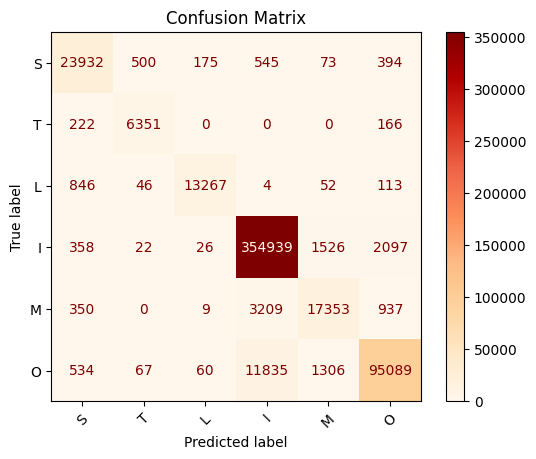

NameError: name 'writer' is not defined

In [13]:
# Evaluation

import os
import matplotlib.pyplot as plt
import numpy as np
import torch


model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v5.pt", map_location=DEVICE))


val_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF (pass labels)
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += loss.item()

        # Decode predictions using CRF (no labels passed)
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)  # List[List[int]]

        # Loop through batch and collect valid tokens
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())


# Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

# F1 Score weighted
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")
# F1 Score macro
f1_macro = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (macro): {f1_macro:.4f}")

# Sequence Level Accuracy
seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Token-level Accuracy
token_acc = accuracy_score(all_labels, all_preds)
print(f"Token-level Accuracy: {token_acc:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

writer.add_scalar("Loss/test", val_loss)

writer.flush()
writer.close()


In [ ]:
import torch
from torchviz import make_dot
from torchview import draw_graph

# Load the model
model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v5.pt"))
model.eval()

# Create dummy inputs matching the expected dimensions
batch_size = 1
seq_length = 512  # maximum token length
dummy_input_ids = torch.randint(0, 1000, (batch_size, seq_length)).to(DEVICE)  
dummy_attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long).to(DEVICE)
# Create dummy labels for the CRF loss computation; filling with -100 so that loss is computed correctly
dummy_labels = torch.full((batch_size, seq_length), -100, dtype=torch.long).to(DEVICE)

# Set the model to evaluation mode
model.eval()

# --- Visualization using torchviz ---
# Forward pass to compute a loss (required for torchviz to trace the graph)
dummy_loss = model(dummy_input_ids, dummy_attention_mask, dummy_labels)
dot = make_dot(dummy_loss, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_visualization_torchviz', view=False)  # Save the graph image without opening it automatically

# --- Visualization using torchview ---
# Draw and display the model graph (adjust parameters as needed)
draw_graph(model, input_size=(batch_size, seq_length), device=DEVICE)